In [18]:
import sys
sys.path.insert(0, "../../../")

# to be included in the photo_meson.py script
import numpy as np
import astropy.units as u
from astropy.constants import c, h, m_p
from agnpy.photo_meson.kernels import PhiKernel, secondaries, eta_0
from agnpy.utils.math import axes_reshaper, ftiny, fmax, log10
from agnpy.utils.conversion import mpc2

# to be used only for the the validation
from astropy.modeling.models import BlackBody
import matplotlib.pyplot as plt
from agnpy.emission_regions import Blob
from agnpy.spectra import PowerLaw, ExpCutoffPowerLaw
from agnpy.photo_meson.photo_meson import PhotoMesonProduction

In [19]:
# Blob with proton population
E_star = 3e20 * u.Unit("eV")
gamma_star = (E_star / mpc2).to_value("")
# p_p, gamma_c, gamma_min, gamma_max = 2, 1e3*gamma_star, (1.0*u.Unit("GeV")/mpc2).to_value(""), 1e6*gamma_star

n_p = ExpCutoffPowerLaw.from_total_energy_density(
    1.0*u.Unit("erg/cm3"),
    mass = m_p,
    p = 2,
    gamma_c = 1e3*gamma_star,
    gamma_min = (1.0*u.Unit("GeV")/mpc2).to_value(""),
    gamma_max = 1e6*gamma_star
    )

blob = Blob(n_p = n_p)
print ("Proton energy density = ", blob.u_p)

Proton energy density =  1.0 erg / cm3


In [20]:
class BlackbodyTarget:
    
    def __init__(self, T):
        self.T = T
        self.bb = BlackBody(T)
        
    def __call__(self, nu):
        return (
            4. * np.pi * u.Unit("sr") * self.bb(nu)
            / (c * h**2 * nu)
        ).to("cm-3 erg-1")

In [21]:
cmb_target = BlackbodyTarget(T = 2.7 * u.Unit("K"))

In [22]:
def plot_spectrum (E, spectrum, particle, power = 1, fig = None, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (8, 6))
    
    ax.loglog(
        E.to("eV"),
        (spectrum * E**power).to(f"erg{power-1} cm-3 s-1"),   # I think there's a mistake in K&A paper.
        label = particle
    )
    ax.set_xlabel("E [eV]")
    if power == 0:
        ylabel = "$\\frac{dN}{dE}$ [erg$^{-1}$ cm$^{-3}$ s$^{-1}$]"
    elif power == 1:
        ylabel = "E $\\frac{dN}{dE}$ [cm$^{-3}$ s$^{-1}$]"
    elif power == 2:
        ylabel = "E$^{2}$ $\\frac{dN}{dE}$ [erg cm$^{-3}$ s$^{-1}$]"
    ax.set_ylabel(ylabel)
    return fig, ax

/home/piotr/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/agnpy/photo_meson/tests/../../../agnpy/photo_meson/kernels.py:65: RuntimeWarning: invalid value encountered in sqrt
  x_2 = np.sqrt((eta - r**2 - 2 * r) * (eta - r**2 + 2 * r))
/home/piotr/Dokumenty/CODE/agnpy/agnpy/photo_meson/tests/../../../agnpy/photo_meson/kernels.py:77: RuntimeWarning: invalid value encountered in sqrt
  x_2 = np.sqrt((eta - r**2 - 2 * r) * (eta - r**2 + 2 * r))
/home/piotr/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *ar

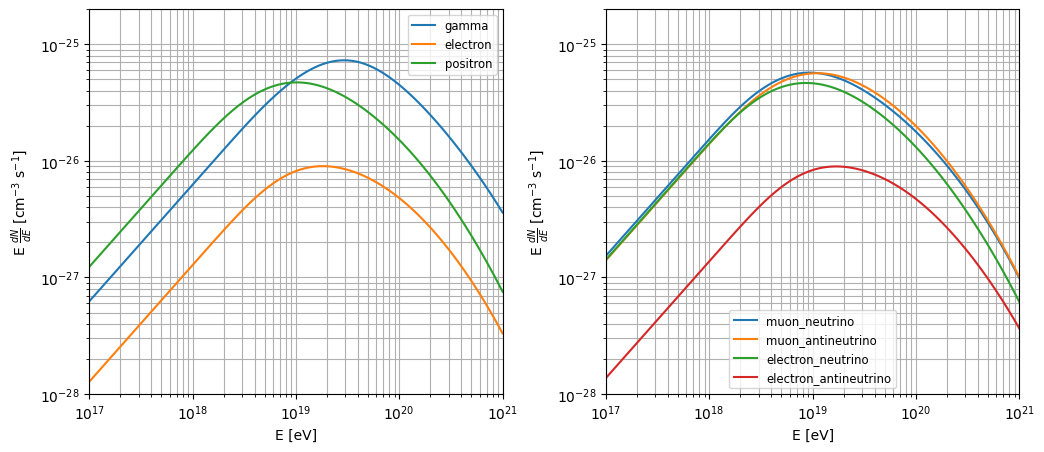

In [23]:
pmp_cmb = PhotoMesonProduction(blob, cmb_target)
E = np.logspace(17, 21, 100) * u.Unit("eV")
particles_left = ["gamma", "electron", "positron"]
particles_right = ["muon_neutrino", "muon_antineutrino", "electron_neutrino", "electron_antineutrino"]

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
fig.subplots_adjust(wspace = 0.25)
for particle in particles_left:
    spectrum = pmp_cmb.evaluate_spectrum(E, particle = particle)
    plot_spectrum(E = E, spectrum = spectrum, power = 1, particle = particle, fig = fig, ax = axs[0])
    
for particle in particles_right:
    spectrum = pmp_cmb.evaluate_spectrum(E, particle = particle)
    plot_spectrum(E = E, spectrum = spectrum, power = 1, particle = particle, fig = fig, ax = axs[1])

for ax in axs:
    ax.set_xlim(1e17,1e21)
    ax.set_ylim(1e-28,2e-25)
    ax.grid(which = "both")
    ax.legend(fontsize = "small")

In [ ]:
# for i in particles_left:

#     E_i, spectrum= np.genfromtxt("../../data/photo_meson/kelner_aharonian_2008/fig17_values/{}.txt".format(i), 
#                           dtype="float", 
#                           delimiter=";",
#                           comments="#", 
#                           usecols=(0, 1), 
#                           unpack="True",
#                           converters={0: lambda x: float(x.replace(',', '.')),
#                                       1: lambda x: float(x.replace(',', '.'))})
#     E_i = np.power(10,E_i)*u.Unit("eV")
#     spectrum = np.power(10,spectrum)*u.Unit("cm-3 s-1")

In [107]:
# print(spectrum)

In [94]:
def plot_spectrum_tab (E, spectrum, particle, power = 1, lw=1, fig = None, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (8, 6))
    
    ax.loglog(
        E.to("eV"),
        (spectrum).to(f"cm-3 s-1"),   # I think there's a mistake in K&A paper.
        label = particle,
        lw=lw
    )
    ax.set_xlabel("E [eV]")
    if power == 0:
        ylabel = "$\\frac{dN}{dE}$ [erg$^{-1}$ cm$^{-3}$ s$^{-1}$]"
    elif power == 1:
        ylabel = "E $\\frac{dN}{dE}$ [cm$^{-3}$ s$^{-1}$]"
    elif power == 2:
        ylabel = "E$^{2}$ $\\frac{dN}{dE}$ [erg cm$^{-3}$ s$^{-1}$]"
    ax.set_ylabel(ylabel)
    return fig, ax

/home/piotr/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/piotr/Dokumenty/CODE/agnpy/agnpy/photo_meson/tests/../../../agnpy/photo_meson/kernels.py:65: RuntimeWarning: invalid value encountered in sqrt
  x_2 = np.sqrt((eta - r**2 - 2 * r) * (eta - r**2 + 2 * r))
/home/piotr/Dokumenty/CODE/agnpy/agnpy/photo_meson/tests/../../../agnpy/photo_meson/kernels.py:77: RuntimeWarning: invalid value encountered in sqrt
  x_2 = np.sqrt((eta - r**2 - 2 * r) * (eta - r**2 + 2 * r))
/home/piotr/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:659: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *ar

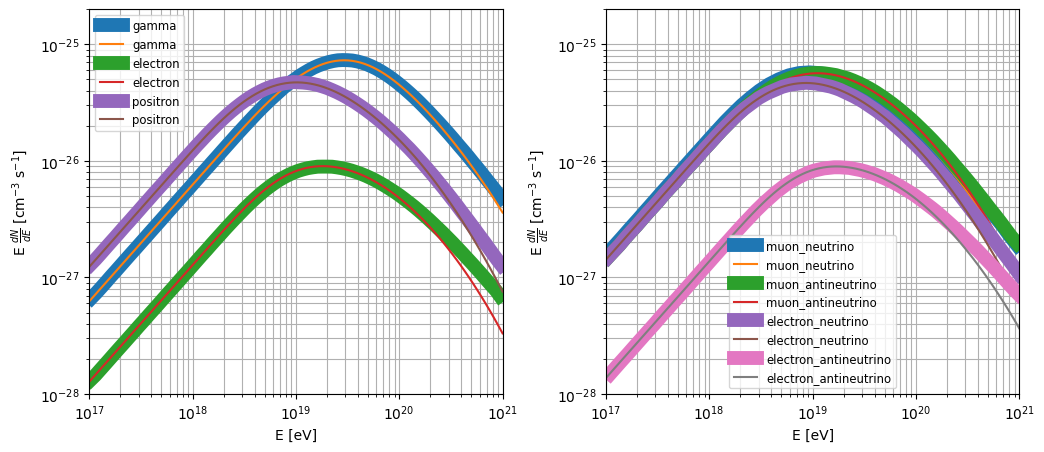

In [109]:
pmp_cmb = PhotoMesonProduction(blob, cmb_target)
E = np.logspace(17, 21, 100) * u.Unit("eV")
particles_left = ["gamma", "electron", "positron"]
particles_right = ["muon_neutrino", "muon_antineutrino", "electron_neutrino", "electron_antineutrino"]

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
fig.subplots_adjust(wspace = 0.25)
for particle in particles_left:
    E_i, spectrum= np.genfromtxt("../../data/photo_meson/kelner_aharonian_2008/fig17_values/{}.txt".format(particle), 
                          dtype="float", 
                          delimiter=";",
                          comments="#", 
                          usecols=(0, 1), 
                          unpack="True",
                          converters={0: lambda x: float(x.replace(',', '.')),
                                      1: lambda x: float(x.replace(',', '.'))})
    # print(E_i,spectrum)
    E_i = np.power(10,E_i)*u.Unit("eV")
    spectrum = np.power(10,spectrum)*u.Unit("cm-3 s-1")
    plot_spectrum_tab(E = E_i, spectrum = spectrum, power = 1, particle = particle, lw=10, fig = fig, ax = axs[0])
    
    spectrum = pmp_cmb.evaluate_spectrum(E, particle = particle)
    plot_spectrum(E = E, spectrum = spectrum, power = 1, particle = particle, fig = fig, ax = axs[0])
    
for particle in particles_right:
    E_i, spectrum= np.genfromtxt("../../data/photo_meson/kelner_aharonian_2008/fig17_values/{}.txt".format(particle), 
                          dtype="float", 
                          delimiter=";",
                          comments="#", 
                          usecols=(0, 1), 
                          unpack="True",
                          converters={0: lambda x: float(x.replace(',', '.')),
                                      1: lambda x: float(x.replace(',', '.'))})
    # print(E_i,spectrum)
    E_i = np.power(10,E_i)*u.Unit("eV")
    spectrum = np.power(10,spectrum)*u.Unit("cm-3 s-1")
    plot_spectrum_tab(E = E_i, spectrum = spectrum, power = 1, particle = particle, lw=10, fig = fig, ax = axs[1])
    
    spectrum = pmp_cmb.evaluate_spectrum(E, particle = particle)
    plot_spectrum(E = E, spectrum = spectrum, power = 1, particle = particle, fig = fig, ax = axs[1])

for ax in axs:
    ax.set_xlim(1e17,1e21)
    ax.set_ylim(1e-28,2e-25)
    ax.grid(which = "both")
    ax.legend(fontsize = "small")